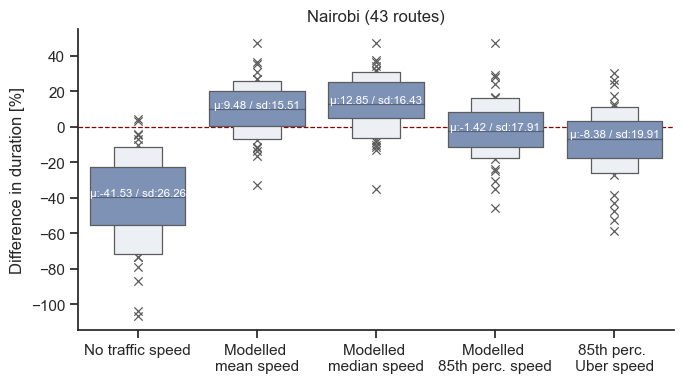

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Plotting route statistics grouped by ORS type as boxenplot to compare Google and ORS routes"""

import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import seaborn as sns
from pathlib import Path


CITY = "nairobi" # insert city name here


def generate_plots(route_data, out_dir, criterion):
    """
    Reads the route data file and generates multiple boxenplots
    :param criterion: column from route dataframe
    :return: boxenplots
    """
    sns.set_theme(style="ticks")
    plt.rc('lines', linewidth=0.9, color='r')
    # Filter routes
    routes = route_data.loc[((route_data.geometry_diff_perc <= 3) & (route_data.distance_diff_perc <= 1) & (route_data.distance_diff_perc >= -1))]
    route_count = routes.groupby('route_id').count()['ors_type']
    full_route_ids = list(route_count.loc[route_count == 5].index)
    routes = routes.loc[routes.route_id.isin(full_route_ids)]

    # filtered route count
    routes_normal_subset = routes.loc[(routes.ors_type == "normal")]
    routes_modelled_mean_subset = routes.loc[(routes.ors_type == "modelled_mean")]
    routes_modelled_p50_subset = routes.loc[(routes.ors_type == "modelled_p50")]
    routes_modelled_p85_subset = routes.loc[(routes.ors_type == "modelled_p85")]
    routes_uber_p85_subset = routes.loc[(routes.ors_type == "uber_p85")]

    order_list = ["normal", "modelled_mean", "modelled_p50", "modelled_p85", "uber_p85"]

    fig = plt.figure(figsize = (7, 4), tight_layout = True)
    #sns.set_style("ticks")

    p = sns.boxenplot(data = routes, x = "ors_type", y = criterion, order = order_list, linewidth=0.9,
                      color = "#7490C0", flier_kws = {"marker": "x"})

    groupby_data = routes.groupby(["ors_type"])[criterion]
    medians = groupby_data.median().reindex(order_list, level = "ors_type")
    means = groupby_data.mean().reindex(order_list, level = "ors_type")
    std = groupby_data.std().reindex(order_list, level = "ors_type")

    # annotate median values to plots
    for xtick in p.get_xticks():
        text_median = p.text(xtick, medians[xtick] + 0.8, "μ:{0:.2f} / sd:{1:.2f}".format(means[xtick], std[xtick]),
                             horizontalalignment = "center",
                             size = "x-small", color = "white") #, weight = "semibold"
        #text_mean = p.text(xtick, means[xtick], round(means[xtick], 2), horizontalalignment = "center", size = "x-small", color = "white", weight = "semibold")

        #text_median.set_path_effects([
        #    path_effects.Stroke(linewidth = 1, foreground = "white"), path_effects.Normal(),
        #])
        #text_mean.set_path_effects([
        #    path_effects.Stroke(linewidth = 1, foreground = "black"), path_effects.Normal(),
        #])
    
    #p.annotate(
    #    "Black/left value: median\nWhite/right value: mean",
    #    xy = (0, 0),
    ##    xytext = (8, 8),
     #   xycoords = "figure points",
    #)
    sns.despine()
    p.set_title(f"{str(CITY).title()} ({routes_modelled_p50_subset.shape[0]} routes)")
    p.set_xticklabels([f"No traffic speed",
                       f"Modelled \nmean speed",
                       f"Modelled \nmedian speed",
                       f"Modelled \n85th perc. speed",
                       f"85th perc. \nUber speed"])
    p.set_xlabel("")
    if criterion == "duration_diff_perc":
        p.set_ylabel("Difference in duration [%]")
    elif criterion == "duration_diff_sec":
        p.set_ylabel("Difference in duration [seconds]")
    elif criterion == "geometry_diff_perc":
        p.set_ylabel("Difference in geometry [%]")
    elif criterion == "geometry_diff_hausdorff":
        p.set_ylabel("Hausdorff distance [deg]")
    p.axhline(0, ls = "--", color = "darkred", zorder = 0)

    fig.savefig(out_dir / f"boxenplot_{CITY}_{criterion}.png", dpi = 300)


if __name__ == "__main__":

    data_dir = "../../data/"
    data_dir = Path(data_dir)
    in_dir = data_dir / CITY / "export"
    out_dir = in_dir / "figures"
    out_dir.mkdir(exist_ok=True)

    item = in_dir / f"{CITY}_results_full.csv"
    route_data = pd.read_csv(item)

    crit_list = ["duration_diff_perc"]

    try:
        for crit in crit_list:
            generate_plots(route_data, out_dir, crit)
    except Exception as e:
        print("ERROR during plotting: ", e)
        sys.exit(0)


In [54]:
from sklearn.metrics import mean_squared_error

In [60]:
routes.groupby(["ors_type"]).apply(lambda x: int(mean_squared_error(x.google_dur_in_traffic_sec, x.ors_dur_sec) / 60.))

ors_type
modelled_mean    2971
modelled_p50     1679
modelled_p85     4615
normal           3253
uber_p85         1735
dtype: int64

,Unnamed: 0,route_id,ors_route,ors_type,hour,google_distance,ors_distance,google_dur_in_traffic_sec,google_dur_sec,ors_dur_sec,duration_diff_sec,duration_diff_perc,google_dist_meter,ors_dist_meter,distance_diff_meter,distance_diff_perc,geometry_diff_perc,geometry_diff_hausdorff,geometry
65,65,h00_5_1,data/berlin/ors_routes_normal/route_normal_00_...,normal,0,32726,32725.6,2580,3164,3210.3,630.3,19.63,32726,32725.6,-0.4,-0.00,0.0116,0.00010,"LINESTRING (13.41862 52.55509, 13.41844 52.555..."
68,68,h00_5_1,data/berlin/ors_routes_modelled_p85/route_mode...,modelled_p85,0,32726,32725.6,2580,3164,1733.5,-846.5,-48.83,32726,32725.6,-0.4,-0.00,0.0116,0.00010,"LINESTRING (13.41862 52.55509, 13.41844 52.555..."
125,125,h00_11_0,data/berlin/ors_routes_normal/route_normal_00_...,normal,0,11148,11176.3,991,1084,1434.4,443.4,30.91,11148,11176.3,28.3,0.25,1.7125,0.00013,"LINESTRING (13.19108 52.45856, 13.1909 52.4586..."
126,126,h00_11_0,data/berlin/ors_routes_modelled_mean/route_mod...,modelled_mean,0,11148,11176.3,991,1084,1019.1,28.1,2.76,11148,11176.3,28.3,0.25,1.7125,0.00013,"LINESTRING (13.19108 52.45856, 13.1909 52.4586..."
127,127,h00_11_0,data/berlin/ors_routes_modelled_p50/route_mode...,modelled_p50,0,11148,11176.3,991,1084,1053.1,62.1,5.90,11148,11176.3,28.3,0.25,1.7125,0.00013,"LINESTRING (13.19108 52.45856, 13.1909 52.4586..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14372,14372,h23_40_1,data/berlin/ors_routes_modelled_p50/route_mode...,modelled_p50,23,13091,13076.4,1271,1546,1013.3,-257.7,-25.43,13091,13076.4,-14.6,-0.11,0.0000,0.00009,"LINESTRING (13.43256 52.54321, 13.4342 52.5426..."
14373,14373,h23_40_1,data/berlin/ors_routes_modelled_p85/route_mode...,modelled_p85,23,13091,13076.4,1271,1546,746.5,-524.5,-70.26,13091,13076.4,-14.6,-0.11,0.0000,0.00009,"LINESTRING (13.43256 52.54321, 13.4342 52.5426..."
14376,14376,h23_40_2,data/berlin/ors_routes_modelled_mean/route_mod...,modelled_mean,23,13129,13106.8,1351,1690,939.9,-411.1,-43.74,13129,13106.8,-22.2,-0.17,0.0000,0.00009,"LINESTRING (13.43256 52.54321, 13.4342 52.5426..."
14377,14377,h23_40_2,data/berlin/ors_routes_modelled_p50/route_mode...,modelled_p50,23,13129,13106.8,1351,1690,1179.7,-171.3,-14.52,13129,13106.8,-22.2,-0.17,0.0000,0.00009,"LINESTRING (13.43256 52.54321, 13.4342 52.5426..."


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import seaborn as sns
from pathlib import Path

In [2]:
CITY = "berlin"
data_dir = "../../data/"
data_dir = Path(data_dir)
in_dir = data_dir / CITY / "export"
out_dir = in_dir / "figures"
out_dir.mkdir(exist_ok=True)

item = in_dir / f"{CITY}_results_full.csv"
route_data = pd.read_csv(item)


In [22]:
route_data

,Unnamed: 0,route_id,ors_route,ors_type,hour,google_distance,ors_distance,google_dur_in_traffic_sec,google_dur_sec,ors_dur_sec,duration_diff_sec,duration_diff_perc,google_dist_meter,ors_dist_meter,distance_diff_meter,distance_diff_perc,geometry_diff_perc,geometry_diff_hausdorff,geometry
0,0,h00_0_0,data/berlin/ors_routes_normal/route_normal_00_...,normal,0,26033,25852.4,1573,1744,1854.7,281.7,15.19,26033,25852.4,-180.6,-0.70,1.8894,0.00209,"LINESTRING (13.13662 52.39893, 13.13658 52.398..."
1,1,h00_0_0,data/berlin/ors_routes_modelled_mean/route_mod...,modelled_mean,0,26033,25289.9,1573,1744,1584.0,11.0,0.69,26033,25289.9,-743.1,-2.94,3.4308,0.00419,"LINESTRING (13.13662 52.39893, 13.13658 52.398..."
2,2,h00_0_0,data/berlin/ors_routes_modelled_p50/route_mode...,modelled_p50,0,26033,25289.9,1573,1744,1694.6,121.6,7.18,26033,25289.9,-743.1,-2.94,3.4308,0.00419,"LINESTRING (13.13662 52.39893, 13.13658 52.398..."
3,3,h00_0_0,data/berlin/ors_routes_modelled_p85/route_mode...,modelled_p85,0,26033,26164.4,1573,1744,1375.8,-197.2,-14.33,26033,26164.4,131.4,0.50,8.0412,0.00872,"LINESTRING (13.13662 52.39893, 13.13658 52.398..."
4,4,h00_0_0,data/berlin/ors_routes_uber_p85/route_uber_p85...,uber_p85,0,26033,25852.4,1573,1744,1868.6,295.6,15.82,26033,25852.4,-180.6,-0.70,1.8894,0.00209,"LINESTRING (13.13662 52.39893, 13.13658 52.398..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14485,14485,h23_49_2,data/berlin/ors_routes_normal/route_normal_23_...,normal,23,9807,10738.2,1022,1232,1255.6,233.6,18.60,9807,10738.2,931.2,8.67,12.7269,0.00522,"LINESTRING (13.22973 52.54417, 13.22988 52.543..."
14486,14486,h23_49_2,data/berlin/ors_routes_modelled_mean/route_mod...,modelled_mean,23,9807,11049.0,1022,1232,946.1,-75.9,-8.02,9807,11049.0,1242.0,11.24,24.2623,0.00522,"LINESTRING (13.22973 52.54417, 13.22988 52.543..."
14487,14487,h23_49_2,data/berlin/ors_routes_modelled_p50/route_mode...,modelled_p50,23,9807,11050.7,1022,1232,1004.2,-17.8,-1.77,9807,11050.7,1243.7,11.25,26.2944,0.00522,"LINESTRING (13.22973 52.54417, 13.22988 52.543..."
14488,14488,h23_49_2,data/berlin/ors_routes_modelled_p85/route_mode...,modelled_p85,23,9807,10843.4,1022,1232,828.7,-193.3,-23.33,9807,10843.4,1036.4,9.56,13.7297,0.00522,"LINESTRING (13.22973 52.54417, 13.22988 52.543..."


In [3]:
routes = route_data.loc[((route_data.geometry_diff_hausdorff < 0.0003) & (route_data.distance_diff_perc < 1) & (route_data.distance_diff_perc > -1))]
routes

,Unnamed: 0,route_id,ors_route,ors_type,hour,google_distance,ors_distance,google_dur_in_traffic_sec,google_dur_sec,ors_dur_sec,duration_diff_sec,duration_diff_perc,google_dist_meter,ors_dist_meter,distance_diff_meter,distance_diff_perc,geometry_diff_perc,geometry_diff_hausdorff,geometry
65,65,h00_5_1,data/berlin/ors_routes_normal/route_normal_00_...,normal,0,32726,32725.6,2580,3164,3210.3,630.3,19.63,32726,32725.6,-0.4,-0.00,0.0116,0.00010,"LINESTRING (13.41862 52.55509, 13.41844 52.555..."
68,68,h00_5_1,data/berlin/ors_routes_modelled_p85/route_mode...,modelled_p85,0,32726,32725.6,2580,3164,1733.5,-846.5,-48.83,32726,32725.6,-0.4,-0.00,0.0116,0.00010,"LINESTRING (13.41862 52.55509, 13.41844 52.555..."
125,125,h00_11_0,data/berlin/ors_routes_normal/route_normal_00_...,normal,0,11148,11176.3,991,1084,1434.4,443.4,30.91,11148,11176.3,28.3,0.25,1.7125,0.00013,"LINESTRING (13.19108 52.45856, 13.1909 52.4586..."
126,126,h00_11_0,data/berlin/ors_routes_modelled_mean/route_mod...,modelled_mean,0,11148,11176.3,991,1084,1019.1,28.1,2.76,11148,11176.3,28.3,0.25,1.7125,0.00013,"LINESTRING (13.19108 52.45856, 13.1909 52.4586..."
127,127,h00_11_0,data/berlin/ors_routes_modelled_p50/route_mode...,modelled_p50,0,11148,11176.3,991,1084,1053.1,62.1,5.90,11148,11176.3,28.3,0.25,1.7125,0.00013,"LINESTRING (13.19108 52.45856, 13.1909 52.4586..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14372,14372,h23_40_1,data/berlin/ors_routes_modelled_p50/route_mode...,modelled_p50,23,13091,13076.4,1271,1546,1013.3,-257.7,-25.43,13091,13076.4,-14.6,-0.11,0.0000,0.00009,"LINESTRING (13.43256 52.54321, 13.4342 52.5426..."
14373,14373,h23_40_1,data/berlin/ors_routes_modelled_p85/route_mode...,modelled_p85,23,13091,13076.4,1271,1546,746.5,-524.5,-70.26,13091,13076.4,-14.6,-0.11,0.0000,0.00009,"LINESTRING (13.43256 52.54321, 13.4342 52.5426..."
14376,14376,h23_40_2,data/berlin/ors_routes_modelled_mean/route_mod...,modelled_mean,23,13129,13106.8,1351,1690,939.9,-411.1,-43.74,13129,13106.8,-22.2,-0.17,0.0000,0.00009,"LINESTRING (13.43256 52.54321, 13.4342 52.5426..."
14377,14377,h23_40_2,data/berlin/ors_routes_modelled_p50/route_mode...,modelled_p50,23,13129,13106.8,1351,1690,1179.7,-171.3,-14.52,13129,13106.8,-22.2,-0.17,0.0000,0.00009,"LINESTRING (13.43256 52.54321, 13.4342 52.5426..."


In [18]:
route_count = routes.groupby('route_id').count()['ors_type']
full_route_ids = list(route_count.loc[route_count == 5].index)
routes.loc[routes.route_id.isin(full_route_ids)]

,Unnamed: 0,route_id,ors_route,ors_type,hour,google_distance,ors_distance,google_dur_in_traffic_sec,google_dur_sec,ors_dur_sec,duration_diff_sec,duration_diff_perc,google_dist_meter,ors_dist_meter,distance_diff_meter,distance_diff_perc,geometry_diff_perc,geometry_diff_hausdorff,geometry
125,125,h00_11_0,data/berlin/ors_routes_normal/route_normal_00_...,normal,0,11148,11176.3,991,1084,1434.4,443.4,30.91,11148,11176.3,28.3,0.25,1.7125,0.00013,"LINESTRING (13.19108 52.45856, 13.1909 52.4586..."
126,126,h00_11_0,data/berlin/ors_routes_modelled_mean/route_mod...,modelled_mean,0,11148,11176.3,991,1084,1019.1,28.1,2.76,11148,11176.3,28.3,0.25,1.7125,0.00013,"LINESTRING (13.19108 52.45856, 13.1909 52.4586..."
127,127,h00_11_0,data/berlin/ors_routes_modelled_p50/route_mode...,modelled_p50,0,11148,11176.3,991,1084,1053.1,62.1,5.90,11148,11176.3,28.3,0.25,1.7125,0.00013,"LINESTRING (13.19108 52.45856, 13.1909 52.4586..."
128,128,h00_11_0,data/berlin/ors_routes_modelled_p85/route_mode...,modelled_p85,0,11148,11176.3,991,1084,916.8,-74.2,-8.09,11148,11176.3,28.3,0.25,1.7125,0.00013,"LINESTRING (13.19108 52.45856, 13.1909 52.4586..."
129,129,h00_11_0,data/berlin/ors_routes_uber_p85/route_uber_p85...,uber_p85,0,11148,11176.3,991,1084,1437.1,446.1,31.04,11148,11176.3,28.3,0.25,1.7125,0.00013,"LINESTRING (13.19108 52.45856, 13.1909 52.4586..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14260,14260,h23_32_0,data/berlin/ors_routes_normal/route_normal_23_...,normal,23,10390,10377.4,838,1004,1001.2,163.2,16.30,10390,10377.4,-12.6,-0.12,0.0000,0.00015,"LINESTRING (13.48426 52.6426, 13.4842 52.64263..."
14261,14261,h23_32_0,data/berlin/ors_routes_modelled_mean/route_mod...,modelled_mean,23,10390,10377.4,838,1004,792.2,-45.8,-5.78,10390,10377.4,-12.6,-0.12,0.0000,0.00015,"LINESTRING (13.48426 52.6426, 13.4842 52.64263..."
14262,14262,h23_32_0,data/berlin/ors_routes_modelled_p50/route_mode...,modelled_p50,23,10390,10377.4,838,1004,884.3,46.3,5.24,10390,10377.4,-12.6,-0.12,0.0000,0.00015,"LINESTRING (13.48426 52.6426, 13.4842 52.64263..."
14263,14263,h23_32_0,data/berlin/ors_routes_modelled_p85/route_mode...,modelled_p85,23,10390,10377.4,838,1004,784.5,-53.5,-6.82,10390,10377.4,-12.6,-0.12,0.0000,0.00015,"LINESTRING (13.48426 52.6426, 13.4842 52.64263..."


In [38]:
a# Filter routes
routes = route_data.loc[((route_data.geometry_diff_hausdorff < 0.0003) & (route_data.distance_diff_perc < 1) & (route_data.distance_diff_perc > -1))]
criterion = 'duration_diff_perc'

In [39]:
routes

,Unnamed: 0,route_id,ors_route,ors_type,hour,google_distance,ors_distance,google_dur_in_traffic_sec,google_dur_sec,ors_dur_sec,duration_diff_sec,duration_diff_perc,google_dist_meter,ors_dist_meter,distance_diff_meter,distance_diff_perc,geometry_diff_perc,geometry_diff_hausdorff,geometry
65,65,h00_5_1,data/berlin/ors_routes_normal/route_normal_00_...,normal,0,32726,32725.6,2580,3164,3210.3,630.3,19.63,32726,32725.6,-0.4,-0.00,100.0,0.00010,"LINESTRING (13.41862 52.55509, 13.41844 52.555..."
68,68,h00_5_1,data/berlin/ors_routes_modelled_p85/route_mode...,modelled_p85,0,32726,32725.6,2580,3164,1733.5,-846.5,-48.83,32726,32725.6,-0.4,-0.00,100.0,0.00010,"LINESTRING (13.41862 52.55509, 13.41844 52.555..."
125,125,h00_11_0,data/berlin/ors_routes_normal/route_normal_00_...,normal,0,11148,11176.3,991,1084,1434.4,443.4,30.91,11148,11176.3,28.3,0.25,100.0,0.00013,"LINESTRING (13.19108 52.45856, 13.1909 52.4586..."
126,126,h00_11_0,data/berlin/ors_routes_modelled_mean/route_mod...,modelled_mean,0,11148,11176.3,991,1084,1019.1,28.1,2.76,11148,11176.3,28.3,0.25,100.0,0.00013,"LINESTRING (13.19108 52.45856, 13.1909 52.4586..."
127,127,h00_11_0,data/berlin/ors_routes_modelled_p50/route_mode...,modelled_p50,0,11148,11176.3,991,1084,1053.1,62.1,5.90,11148,11176.3,28.3,0.25,100.0,0.00013,"LINESTRING (13.19108 52.45856, 13.1909 52.4586..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14372,14372,h23_40_1,data/berlin/ors_routes_modelled_p50/route_mode...,modelled_p50,23,13091,13076.4,1271,1546,1013.3,-257.7,-25.43,13091,13076.4,-14.6,-0.11,100.0,0.00009,"LINESTRING (13.43256 52.54321, 13.4342 52.5426..."
14373,14373,h23_40_1,data/berlin/ors_routes_modelled_p85/route_mode...,modelled_p85,23,13091,13076.4,1271,1546,746.5,-524.5,-70.26,13091,13076.4,-14.6,-0.11,100.0,0.00009,"LINESTRING (13.43256 52.54321, 13.4342 52.5426..."
14376,14376,h23_40_2,data/berlin/ors_routes_modelled_mean/route_mod...,modelled_mean,23,13129,13106.8,1351,1690,939.9,-411.1,-43.74,13129,13106.8,-22.2,-0.17,100.0,0.00009,"LINESTRING (13.43256 52.54321, 13.4342 52.5426..."
14377,14377,h23_40_2,data/berlin/ors_routes_modelled_p50/route_mode...,modelled_p50,23,13129,13106.8,1351,1690,1179.7,-171.3,-14.52,13129,13106.8,-22.2,-0.17,100.0,0.00009,"LINESTRING (13.43256 52.54321, 13.4342 52.5426..."


In [13]:
routes.loc[routes.route_id == "h09_20_0"]

,Unnamed: 0,route_id,ors_route,ors_type,hour,google_distance,ors_distance,google_dur_in_traffic_sec,google_dur_sec,ors_dur_sec,duration_diff_sec,duration_diff_perc,google_dist_meter,ors_dist_meter,distance_diff_meter,distance_diff_perc,geometry_diff_perc,geometry_diff_hausdorff,geometry
5685,5685,h09_20_0,data/berlin/ors_routes_normal/route_normal_09_...,normal,9,10230,10221.7,1784,1445,1115.8,-668.2,-59.89,10230,10221.7,-8.3,-0.08,99.9862,0.00009,"LINESTRING (13.41999 52.58737, 13.42057 52.586..."


In [15]:
route_data.loc[route_data.route_id == "h09_20_0"]

,Unnamed: 0,route_id,ors_route,ors_type,hour,google_distance,ors_distance,google_dur_in_traffic_sec,google_dur_sec,ors_dur_sec,duration_diff_sec,duration_diff_perc,google_dist_meter,ors_dist_meter,distance_diff_meter,distance_diff_perc,geometry_diff_perc,geometry_diff_hausdorff,geometry
5685,5685,h09_20_0,data/berlin/ors_routes_normal/route_normal_09_...,normal,9,10230,10221.7,1784,1445,1115.8,-668.2,-59.89,10230,10221.7,-8.3,-0.08,99.9862,0.00009,"LINESTRING (13.41999 52.58737, 13.42057 52.586..."
5686,5686,h09_20_0,data/berlin/ors_routes_modelled_mean/route_mod...,modelled_mean,9,10230,10319.2,1784,1445,1108.6,-675.4,-60.92,10230,10319.2,89.2,0.86,99.9864,0.00188,"LINESTRING (13.41999 52.58737, 13.42057 52.586..."
5687,5687,h09_20_0,data/berlin/ors_routes_modelled_p50/route_mode...,modelled_p50,9,10230,10319.2,1784,1445,1270.3,-513.7,-40.44,10230,10319.2,89.2,0.86,99.9864,0.00188,"LINESTRING (13.41999 52.58737, 13.42057 52.586..."
5688,5688,h09_20_0,data/berlin/ors_routes_modelled_p85/route_mode...,modelled_p85,9,10230,10208.1,1784,1445,705.9,-1078.1,-152.73,10230,10208.1,-21.9,-0.21,99.9862,0.00111,"LINESTRING (13.41999 52.58737, 13.42057 52.586..."
5689,5689,h09_20_0,data/berlin/ors_routes_uber_p85/route_uber_p85...,uber_p85,9,10230,10208.1,1784,1445,1264.5,-519.5,-41.08,10230,10208.1,-21.9,-0.21,99.9862,0.00111,"LINESTRING (13.41999 52.58737, 13.42057 52.586..."


In [110]:

# filtered route count
routes_normal_subset = routes.loc[(routes.ors_type == "normal")]
routes_modelled_mean_subset = routes.loc[(routes.ors_type == "modelled_mean")]
routes_modelled_p50_subset = routes.loc[(routes.ors_type == "modelled_p50")]
routes_modelled_p85_subset = routes.loc[(routes.ors_type == "modelled_p85")]
routes_uber_p85_subset = routes.loc[(routes.ors_type == "uber_p85")]



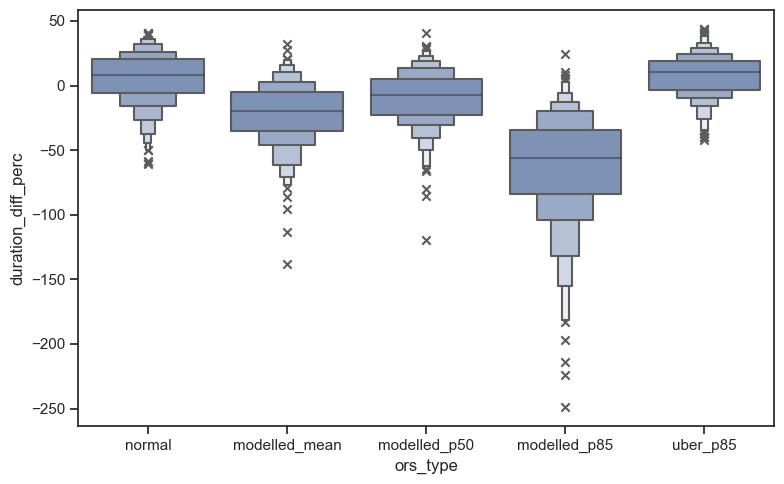

In [111]:
order_list = ["normal", "modelled_mean", "modelled_p50", "modelled_p85", "uber_p85"]

fig = plt.figure(figsize = (8, 5), tight_layout = True)
sns.set_style("ticks")

p = sns.boxenplot(data = routes, x = "ors_type", y = criterion, order = order_list,
                  color = "#7490C0", flier_kws = {"marker": "x"})


In [115]:
import geopandas as gpd

In [123]:
city = 'cincinnati'

In [124]:
data = gpd.read_file(f'/Users/cludwig/Development/sm2t/sm2t-foss4g/data/{city}/google_routes/{city}_50_routes_per_hour.geojson')
len(data)

2796